<a href="https://colab.research.google.com/github/preetamjumech/LLM/blob/main/LanguageTranslation_LSTMs_Attention_17_11_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "tensorflow-text>=2.11"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [3]:
import string
import random

import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [32]:
with open("/content/fra.txt") as f:
    lines = f.read().split("\n")[:-1]

    text_pairs = []

    for line in lines:
        eng, fra = line.split("\t")
        fra = "[start] " + fra + " [end]"
        text_pairs.append((eng, fra))

In [33]:
for _ in range(10):
    print(random.choice(text_pairs))

('I extended my holiday.', "[start] J'ai prolongé mes vacances. [end]")
('The house is vacant.', '[start] La maison est inoccupée. [end]')
('The museum is open to the public.', '[start] Le musée est ouvert au public. [end]')
("That's not the way I see it.", "[start] Ce n'est pas ainsi que je le vois. [end]")
('They drive on the left in England.', '[start] Ils roulent à gauche en Angleterre. [end]')
("I know someone needs to tell Tom about Mary's death. Does it have to be me?", "[start] Je sais que quelqu'un doit le dire à Tom pour la mort de Mary. Mais est-ce que ça doit être moi ? [end]")
('They were talking about you.', '[start] Elles parlaient de vous. [end]')
('We enjoyed ourselves at the party.', "[start] On s'est bien amusé à la fête. [end]")
('Our work never ends.', "[start] Notre travail ne s'arrête jamais. [end]")
("I'm sure that's what Tom would've wanted.", "[start] Je suis sûr que c'est ce que Tom aurait voulu. [end]")


In [34]:
text_pairs = text_pairs[:1000]
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1000 total pairs
700 training pairs
150 validation pairs
150 test pairs


In [35]:
def tf_lower_and_split_punct(text):

    """
      Processes text before vectorization.
    """
    # French text contains special symbols. Unicode normalization:
    text = tf_text.normalize_utf8(text, "NFKD")

    # Lowercase
    text = tf.strings.lower(text)

    # Keep space, a to z, and select punctuation and square brackets.
    text = tf.strings.regex_replace(text, "[^ a-z.?!,\]\[]", "")

    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,]", r" \0 ")

    # Strip whitespace.
    text = tf.strings.strip(text)

    return text

In [36]:
vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
    standardize = tf_lower_and_split_punct
)

fra_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1,
    standardize = tf_lower_and_split_punct,
)

In [37]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
fra_vectorization.adapt(train_fra_texts)

In [38]:
vocab_inp_size = len(eng_vectorization.get_vocabulary())

vocab_inp_size

339

In [39]:
eng_vectorization.get_vocabulary()[:15]

['',
 '[UNK]',
 '.',
 'i',
 '!',
 'im',
 'it',
 'go',
 '?',
 'me',
 'tom',
 'up',
 'its',
 'we',
 'this']

In [40]:
vocab_out_size = len(fra_vectorization.get_vocabulary())

vocab_out_size

631

In [41]:
fra_vectorization.get_vocabulary()[:15]

['',
 '[UNK]',
 '[start]',
 '[end]',
 '.',
 '!',
 'je',
 'suis',
 '?',
 'tom',
 'jai',
 'cest',
 'a',
 'nous',
 'est']

In [42]:
import tensorflow as tf

def format_dataset(eng, fra):
    eng = eng_vectorization(eng)
    fra = fra_vectorization(fra)

    # (english tokens, french tokens, french tokens shifted by 1)
    return eng, fra[:, :-1], fra[:, 1:]

def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)

    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))

    dataset = dataset.batch(batch_size, drop_remainder = True)

    dataset = dataset.map(format_dataset)

    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [43]:
encoder_inputs, decoder_inputs, targets = next(iter(train_ds))

encoder_inputs.shape, decoder_inputs.shape, targets.shape

(TensorShape([64, 20]), TensorShape([64, 20]), TensorShape([64, 20]))

In [44]:
encoder_inputs

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 13,  29,   6, ...,   0,   0,   0],
       [333,   4,   0, ...,   0,   0,   0],
       [  5, 130,   2, ...,   0,   0,   0],
       ...,
       [ 85,   6,   2, ...,   0,   0,   0],
       [ 12, 112,   2, ...,   0,   0,   0],
       [ 66,  41,   2, ...,   0,   0,   0]])>

In [45]:
decoder_inputs

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  2,  13, 104, ...,   0,   0,   0],
       [  2, 488,   5, ...,   0,   0,   0],
       [  2,   6,   7, ...,   0,   0,   0],
       ...,
       [  2,  11,  15, ...,   0,   0,   0],
       [  2,  11, 102, ...,   0,   0,   0],
       [  2,  39, 621, ...,   0,   0,   0]])>

In [46]:
targets

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 13, 104, 116, ...,   0,   0,   0],
       [488,   5,   3, ...,   0,   0,   0],
       [  6,   7,  17, ...,   0,   0,   0],
       ...,
       [ 11,  15,   4, ...,   0,   0,   0],
       [ 11, 102,   4, ...,   0,   0,   0],
       [ 39, 621,  47, ...,   0,   0,   0]])>

In [47]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim

        # Define the embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        # Define the RNN layer with LSTM cells
        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

    def call(self, input_sequence, states):

        # Input shape: (batch_size, sequence_length)

        # Embed the input
        embed = self.embedding(input_sequence)

        # Embed shape: (batch_size, sequence_length, embedding_dim)

        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state = states)

        # Output shape: (batch_size, sequence_length, hidden_dim)
        # state_h shape: (batch_size, hidden_dim)
        # state_c shape: (batch_size, hidden_dim)

        return output, state_h, state_c

    def init_states(self, batch_size):

        # Return all 0s initial states
        return (
            tf.zeros([batch_size, self.hidden_dim]),
            tf.zeros([batch_size, self.hidden_dim])
        )

In [48]:
embedding_dim = 128
hidden_units = 256

# Create the Encoder
encoder = Encoder(vocab_inp_size, embedding_dim, hidden_units)

# Getting initial states
initial_state = encoder.init_states(batch_size = 1)

# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 5, 10, 15, 20, 25]]), initial_state)

# outputs, state_h, state_c
test_encoder_output[0].shape, test_encoder_output[2].shape, test_encoder_output[2].shape

(TensorShape([1, 6, 256]), TensorShape([1, 256]), TensorShape([1, 256]))

In [49]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim

        # Define the embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        # Define the RNN layer with LSTM cell
        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

        self.dense = layers.Dense(vocab_size)

    def call(self, input_sequence, state):

        # Input shape: (batch_size, sequence_length)

        # Embed the input
        embed = self.embedding(input_sequence)

        # Embed shape: (batch_size, sequence_length, embedding_dim)

        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)

        # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        # state_h shape: (batch_size, hidden_dim)
        # state_c shape: (batch_size, hidden_dim)

        # Dense layer to predict output token
        outputs = self.dense(lstm_out)

        # Output shape: (batch_size, sequence_length, vocab_size)

        return outputs, state_h, state_c

In [50]:
# Create the Decoder
decoder = Decoder(vocab_out_size, embedding_dim, hidden_units)

# Get the initial states
de_initial_state = test_encoder_output[1:]

# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 6, 12, 18, 24, 30, 36, 42]]), de_initial_state)

test_decoder_output[0].shape, test_decoder_output[2].shape, test_decoder_output[2].shape

(TensorShape([1, 8, 631]), TensorShape([1, 256]), TensorShape([1, 256]))

In [51]:
from tensorflow.keras import backend as K

def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True)

    # Mask padding values, they should not be included in the loss
    # In the mask all values equal to 0 in vector will be 0, rest 1
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype = tf.int64)

    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight = mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape: (batch_size, sequence_length, vocab_size)
    # y_true shape: (batch_size, sequence_length)

    # Get predicted tokens shape: (batch_size, sequence_length)
    pred_values = K.cast(K.argmax(y_pred, axis = -1), dtype = "int64")

    correct = K.cast(K.equal(y_true, pred_values), dtype = "float32")

    # 0 is padding, don't include those, everything else
    # will be an integer token
    mask = K.cast(K.greater(y_true, 0), dtype = "float32")

    # Number of correct words predicted
    n_correct = K.sum(mask * correct)

    # Total number of words
    n_total = K.sum(mask)

    return n_correct / n_total

In [52]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):

    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:

        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)

        # Get the hidden states of the encoder to pass to the decoder
        de_states = en_outputs[1:]

        # Get the decoder outputs
        de_outputs = decoder(target_seq_in, de_states)

        # Take the actual output
        logits = de_outputs[0]

        # Calculate the loss and accuracy
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables

    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)

    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [53]:
@tf.function
def valid_step(val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states):

    # Get the encoder outputs
    en_outputs = encoder(val_input_seq, en_initial_states)

    # Get the hidden states of the encoder to pass to the decoder
    de_states = en_outputs[1:]

    # Get the decoder outputs
    de_outputs = decoder(val_target_seq_in, de_states)

    # Take the actual output
    logits = de_outputs[0]

    # Calculate the loss function
    valid_loss = loss_func(val_target_seq_out, logits)
    valid_acc = accuracy_fn(val_target_seq_out, logits)

    return valid_loss, valid_acc


In [54]:
optimizer = tf.keras.optimizers.Adam(clipnorm = 5.0)

In [55]:
epoch_train_losses = []
epoch_train_accuracies = []

epoch_val_losses = []
epoch_val_accuracies = []

num_epochs = 7

for epochs in range(num_epochs):

    en_initial_states = encoder.init_states(batch_size)

    train_losses = []
    train_accuracies = []

    for i, (input_seq, target_seq_in, target_seq_out) in enumerate(train_ds.take(-1)):
        loss, accuracy = train_step(
            input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)

        train_losses.append(loss)
        train_accuracies.append(accuracy)

    # Calculate average training loss and accuracy
    avg_train_loss = tf.reduce_mean(train_losses)
    avg_train_accuracy = tf.reduce_mean(train_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(avg_train_accuracy)

    val_losses = []
    val_accuracies = []

    for j, (val_input_seq, val_target_seq_in, val_target_seq_out) in enumerate(val_ds.take(-1)):
        valid_loss, valid_accuracy = valid_step(
            val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states)

        val_losses.append(valid_loss)
        val_accuracies.append(valid_accuracy)

    # Calculate average validation loss and accuracy
    avg_val_loss = tf.reduce_mean(val_losses)
    avg_val_accuracy = tf.reduce_mean(val_accuracies)

    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(avg_val_accuracy)

    print("Epoch {} "
          "Avg Train Loss: {:.4f} "
          "Avg Train Acc: {:.4f}  "
          "Avg Validation Loss: {:.4f}  "
          "Avg Val Acc: {:.4f}".format(
              epochs + 1,
              avg_train_loss.numpy(),
              avg_train_accuracy.numpy(),
              avg_val_loss.numpy(),
              avg_val_accuracy.numpy())
    )

Epoch 1 Avg Train Loss: 1.2608 Avg Train Acc: 0.2104  Avg Validation Loss: 0.9430  Avg Val Acc: 0.2211
Epoch 2 Avg Train Loss: 0.8963 Avg Train Acc: 0.2675  Avg Validation Loss: 0.9066  Avg Val Acc: 0.3454
Epoch 3 Avg Train Loss: 0.8382 Avg Train Acc: 0.3307  Avg Validation Loss: 0.8912  Avg Val Acc: 0.4007
Epoch 4 Avg Train Loss: 0.8014 Avg Train Acc: 0.3740  Avg Validation Loss: 0.8660  Avg Val Acc: 0.4266
Epoch 5 Avg Train Loss: 0.7690 Avg Train Acc: 0.4315  Avg Validation Loss: 0.8479  Avg Val Acc: 0.4318
Epoch 6 Avg Train Loss: 0.7435 Avg Train Acc: 0.4586  Avg Validation Loss: 0.8413  Avg Val Acc: 0.4577
Epoch 7 Avg Train Loss: 0.7257 Avg Train Acc: 0.4611  Avg Validation Loss: 0.8358  Avg Val Acc: 0.4577


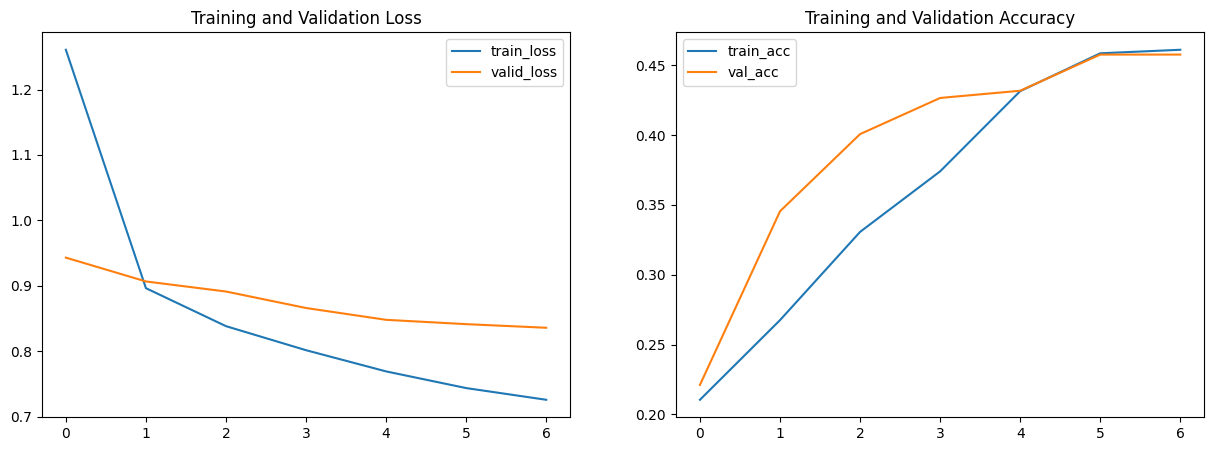

In [56]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# losses
ax1.plot(epoch_train_losses, label = "train_loss")
ax1.plot(epoch_val_losses, label = "valid_loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# accuracies
ax2.plot(epoch_train_accuracies, label = "train_acc")
ax2.plot(epoch_val_accuracies, label = "val_acc")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
plt.show()

In [57]:
def translate_sentence(input_sentence, decoded_max_len):
    # Tokenize the input sequence
    tokenized_input_sentence = eng_vectorization([input_sentence])

    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)

    # Get the encoder outputs (including hidden states)
    en_outputs = encoder(tf.constant(tokenized_input_sentence), en_initial_states)

    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]

    # Create the decoder input, the sos token
    de_input = tf.constant([[fra_vectorization.get_vocabulary().index("[start]")]])

    out_words = []

    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))

        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)

        # Append the word to the predicted output
        out_words.append(fra_index_lookup[de_input.numpy()[0][0]])

        # Finish when eos token is found or the max length is reached
        if out_words[-1] == "[end]" or len(out_words) >= decoded_max_len:
            break

    print("Input :", input_sentence[0])
    print("Predicted translation :", " ".join(out_words))

In [58]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]

fra_vocab = fra_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))

for _ in range(30):

    # Choose a random index
    random_index = random.randint(0, len(test_eng_texts) - 1)

    input_text = test_eng_texts[random_index]
    target_text = test_fra_texts[random_index]
    test_sents = [input_text]

    translate_sentence(test_sents, 20)
    print("Actual translation :", target_text)
    print()

Input : Get a job.
Predicted translation : je suis . [end]
Actual translation : [start] Trouvez un emploi ! [end]

Input : Welcome.
Predicted translation : je suis . [end]
Actual translation : [start] Bienvenue ! [end]

Input : Be nice.
Predicted translation : je suis . [end]
Actual translation : [start] Soyez gentille ! [end]

Input : Hurry up.
Predicted translation : je suis . [end]
Actual translation : [start] Fiça ! [end]

Input : Back off!
Predicted translation : je suis . [end]
Actual translation : [start] Reculez. [end]

Input : Call Tom.
Predicted translation : je suis . [end]
Actual translation : [start] Appelle Tom. [end]

Input : I'm rich.
Predicted translation : je suis . [end]
Actual translation : [start] Je suis riche. [end]

Input : I'm full.
Predicted translation : je suis . [end]
Actual translation : [start] Je suis rassasié ! [end]

Input : I had fun.
Predicted translation : je suis . [end]
Actual translation : [start] Je me suis marrée. [end]

Input : I'm stuck.
Pred

# With attention

In [59]:
class Attention(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.wa = layers.Dense(hidden_dim)

    def call(self, decoder_output, encoder_output):
        # General score function: decoder_output (dot) (Wa (dot) encoder_output)

        # Decoder output is fed in one word at a time to attention layer
        # decoder_output has shape: (batch_size, 1, hidden_dim)

        # encoder_output has shape: (batch_size, sequence_length, hidden_dim)

        # => score has shape: (batch_size, 1, sequence_length)
        score = tf.matmul(
            decoder_output,
            self.wa(encoder_output), transpose_b = True
        )

        # alignment = softmax(score)
        attention = tf.keras.activations.softmax(score, axis = -1)
        # (batch_size, 1, sequence_length)

        # context vector is the weighted average sum of encoder output
        context = tf.matmul(attention, encoder_output)
        # (batch_size, 1, hidden_dim)

        return context, attention

In [60]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim

        self.attention = Attention(hidden_dim)

        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

        self.wc = layers.Dense(hidden_dim, activation = "tanh")
        self.ws = layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # input_sequence shape: (batch_size, 1)

        embed = self.embedding(input_sequence)
        # embed shape: (batch_size, 1, embedding_dim)

        lstm_out, state_h, state_c = self.lstm(embed, initial_state = state)
        # lstm_out shape: (batch_size, 1, hidden_dim)

        # Use self.attention to compute the context and alignment vectors
        # context shape: (batch_size, 1, hidden_dim)
        # alignment shape: (batch_size, 1, sequence_length)
        context, attention = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combining, both have shape of (batch_size, 1, hidden_dim),
        # so let;s squeeze the axis 1 first
        # Shape after combining (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Converted back to vocabulary space: (batch_size, vocab_size)
        outputs = self.ws(lstm_out)

        return outputs, state_h, state_c, attention

In [61]:
embedding_dim = 128
hidden_units = 256

encoder = Encoder(vocab_inp_size, embedding_dim, hidden_units)
decoder = Decoder(vocab_out_size, embedding_dim, hidden_units)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)

encoder_outputs = encoder(tf.constant([[1, 2, 3, 4, 5]]), initial_state)

decoder_outputs = decoder(tf.constant(
    [[2]]), encoder_outputs[1:], encoder_outputs[0])

decoder_outputs[0].shape

TensorShape([1, 631])

In [62]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    loss = 0.
    acc = 0.
    logits = None

    en_initial_states = encoder.init_states(batch_size)

    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)

        de_state_h, de_state_c = en_outputs[1:]

        # Shape of target_seq_out (batch_size, sequence_length)

        # Iterate over each word in the target sequence
        for i in range(target_seq_out.shape[1]):

            # Input to the decoder must have shape of (batch_size, 1)
            # so we need to expand one dimension
            # (batch_size, ) -> (batch_size, 1)
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)

            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

            # Store the logits to calculate the accuracy
            # Shape (batch_size, vocab_size) -> (batch_size, 1, vocab_size)
            logit = K.expand_dims(logit, axis = 1)

            # Next word predicted in the output
            # logit shape: (batch_size, 1, vocab_size)

            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits, logit), axis = 1)

        # Logits of complete output
        # logits shape: (batch_size, sequence_length, vocab_size)

        # Calculate the accuracy for the batch data
        acc = accuracy_fn(target_seq_out, logits)

    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

In [63]:
@tf.function
def valid_step(val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states):
    loss = 0.
    acc = 0.
    logits = None

    # Get the encoder outputs
    en_outputs = encoder(val_input_seq, en_initial_states)
    de_state_h, de_state_c = en_outputs[1:]

    # Shape of target_seq_out (batch_size, sequence_length)

    # Iterate over each word in the target sequence
    for i in range(val_target_seq_out.shape[1]):
        # Input to the decoder must have shape of (batch_size, 1)
        # so we need to expand one dimension
        decoder_in = tf.expand_dims(val_target_seq_in[:, i], 1)

        logit, de_state_h, de_state_c, _ = decoder(
            decoder_in, (de_state_h, de_state_c), en_outputs[0])

        # The loss is now accumulated through the whole batch
        loss += loss_func(val_target_seq_out[:, i], logit)

        # Store the logits to calculate the accuracy
        logit = tf.expand_dims(logit, axis=1)

        if logits is None:
            logits = logit
        else:
            logits = tf.concat((logits, logit), axis=1)

    # Calculate the accuracy for the batch data
    acc = accuracy_fn(val_target_seq_out, logits)

    return loss / val_target_seq_out.shape[1], acc


In [64]:
optimizer = tf.keras.optimizers.Adam(clipnorm = 5.0)

In [65]:
epoch_train_losses = []
epoch_train_accuracies = []

epoch_val_losses = []
epoch_val_accuracies = []

num_epochs = 7

for epochs in range(num_epochs):

    en_initial_states = encoder.init_states(batch_size)

    train_losses = []
    train_accuracies = []

    for i, (input_seq, target_seq_in, target_seq_out) in enumerate(train_ds.take(-1)):
        loss, accuracy = train_step(
            input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer,)

        train_losses.append(loss)
        train_accuracies.append(accuracy)

    # Calculate average training loss and accuracy
    avg_train_loss = tf.reduce_mean(train_losses)
    avg_train_accuracy = tf.reduce_mean(train_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(avg_train_accuracy)

    val_losses = []
    val_accuracies = []

    for j, (val_input_seq, val_target_seq_in, val_target_seq_out) in enumerate(val_ds.take(-1)):
        valid_loss, valid_accuracy = valid_step(
            val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states)

        val_losses.append(valid_loss)
        val_accuracies.append(valid_accuracy)

    # Calculate average validation loss and accuracy
    avg_val_loss = tf.reduce_mean(val_losses)
    avg_val_accuracy = tf.reduce_mean(val_accuracies)

    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(avg_val_accuracy)

    print("Epoch {} "
          "Avg Train Loss: {:.4f} "
          "Avg Train Acc: {:.4f}  "
          "Avg Validation Loss: {:.4f}  "
          "Avg Val Acc: {:.4f}".format(epochs + 1,
                                  avg_train_loss.numpy(),
                                  avg_train_accuracy.numpy(),
                                  avg_val_loss.numpy(),
                                  avg_val_accuracy.numpy())
    )

Epoch 1 Avg Train Loss: 1.1872 Avg Train Acc: 0.1967  Avg Validation Loss: 0.9718  Avg Val Acc: 0.1503
Epoch 2 Avg Train Loss: 0.9043 Avg Train Acc: 0.2334  Avg Validation Loss: 0.9036  Avg Val Acc: 0.3592
Epoch 3 Avg Train Loss: 0.8400 Avg Train Acc: 0.3202  Avg Validation Loss: 0.9019  Avg Val Acc: 0.2953
Epoch 4 Avg Train Loss: 0.7991 Avg Train Acc: 0.3496  Avg Validation Loss: 0.8819  Avg Val Acc: 0.3989
Epoch 5 Avg Train Loss: 0.7520 Avg Train Acc: 0.4188  Avg Validation Loss: 0.8705  Avg Val Acc: 0.4300
Epoch 6 Avg Train Loss: 0.7208 Avg Train Acc: 0.4561  Avg Validation Loss: 0.8444  Avg Val Acc: 0.4577
Epoch 7 Avg Train Loss: 0.6967 Avg Train Acc: 0.4614  Avg Validation Loss: 0.8421  Avg Val Acc: 0.4594


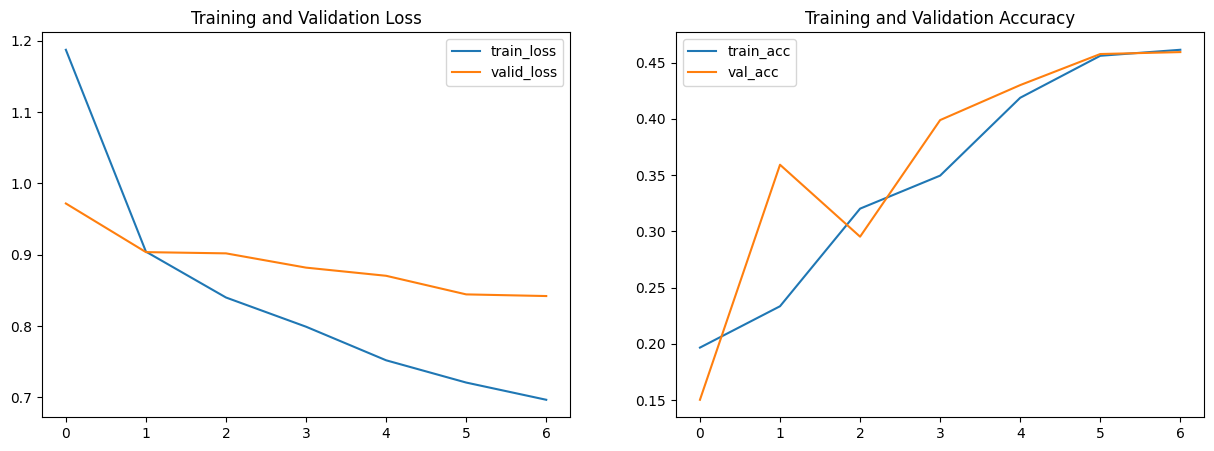

In [66]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# losses
ax1.plot(epoch_train_losses, label = "train_loss")
ax1.plot(epoch_val_losses, label = "valid_loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# accuracies
ax2.plot(epoch_train_accuracies, label = "train_acc")
ax2.plot(epoch_val_accuracies, label = "val_acc")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
plt.show()

In [67]:
def translate_sentence_with_attention(input_sentence, encoder, decoded_max_len):
    # Tokenize the input text
    tokenized_input_sentence = eng_vectorization([input_sentence])

    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)

    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(tokenized_input_sentence), en_initial_states)

    # Set the decoder input to the sos token
    de_input = tf.constant([[fra_vectorization.get_vocabulary().index("[start]")]])

    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]

    out_words = []
    attention_weights = []

    fra_vocab = fra_vectorization.get_vocabulary()
    fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, attention = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])

        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)

        # Detokenize the output
        out_words.append(fra_index_lookup[de_input.numpy()[0][0]])

        # Save the aligment matrix
        attention_weights.append(attention.numpy())

        if out_words[-1] == "[end]" or len(out_words) >= decoded_max_len:
            break

    print("Input :", input_sentence)

    # Join the output words
    print("Predicted translation :", " ".join(out_words))

    return np.array(attention_weights), input_sentence.split(" "), out_words

In [69]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]

for _ in range(30):
    # Choose a random index
    random_index = random.randint(0, len(test_eng_texts) - 1)

    input_text = test_eng_texts[random_index]
    target_text = test_fra_texts[random_index]
    test_sents = [input_text]

    translate_sentence_with_attention(test_sents[0], encoder, 20)
    print("Actual translation :", target_text)
    print()

Input : Be nice.
Predicted translation : je suis . [end]
Actual translation : [start] Sois gentille ! [end]

Input : Get out.
Predicted translation : je suis . [end]
Actual translation : [start] Casse-toi. [end]

Input : I'm tidy.
Predicted translation : je suis . [end]
Actual translation : [start] Je suis ordonné. [end]

Input : What fun!
Predicted translation : je suis . [end]
Actual translation : [start] Qu'est-ce qu'on s'est marrés ! [end]

Input : I am fat.
Predicted translation : je suis . [end]
Actual translation : [start] Je suis gras. [end]

Input : It's odd.
Predicted translation : je suis . [end]
Actual translation : [start] C'est bizarre. [end]

Input : Call Tom.
Predicted translation : je suis . [end]
Actual translation : [start] Appelle Tom. [end]

Input : Is it hot?
Predicted translation : je suis . [end]
Actual translation : [start] Est-ce chaud ? [end]

Input : I'll cook.
Predicted translation : je suis . [end]
Actual translation : [start] Je cuisinerai. [end]

Input :

Input : you have a lot of strange ideas .
Predicted translation : je suis . [end]


<ipython-input-71-37920296982a>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + source, rotation=90)
<ipython-input-71-37920296982a>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + prediction)


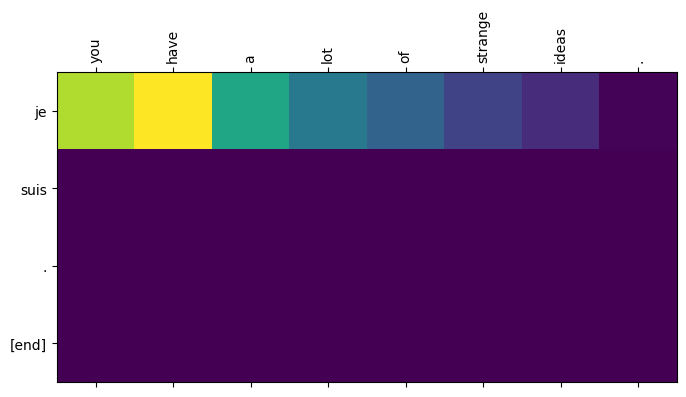

In [71]:
# test_sents = ["You are young and strong ."]
# test_sents = ["The train was on time ."]
# test_sents= ["It is a difficult language ."]
# test_sents = ["you are taller than me ."]
test_sents = ["you have a lot of strange ideas ."]

# Create the figure to plot in
fig = plt.figure(figsize = (8, 8))

for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    attention_weights, source, prediction = translate_sentence_with_attention(test_sent, encoder, 20)
    attention = np.squeeze(attention_weights, (1, 2))

    # Create a subplot
    ax = fig.add_subplot(1, 1, i+1)
    ax.matshow(attention[:len(prediction), :len(source)], cmap = "viridis")
    ax.set_xticklabels([""] + source, rotation=90)
    ax.set_yticklabels([""] + prediction)

plt.show()